# Day 2 — Learning Curves & Bias–Variance Diagnosis
### Machine Learning Roadmap — Week 3
### Author — N Manish Kumar
---

In the previous notebook, we tuned hyperparameters using GridSearchCV.
However, tuning alone does not always fix poor model performance.

To improve a model correctly, we must first understand whether it is
suffering from **high bias (underfitting)** or **high variance (overfitting)**.

Learning curves help visualize:
- How training performance changes with more data
- How validation performance changes with more data

By analyzing these curves, we can decide whether we should:
- Add more data
- Add better features
- Increase or decrease model complexity

In this notebook, we will:
- Plot learning curves for Logistic Regression
- Diagnose bias vs variance
- Compare regularized vs less-regularized models

Dataset used: **Breast Cancer Dataset (sklearn)**

---

## 1. Importing Dataset and Train-Test Split


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load dataset
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split (hold-out test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in training set:\n", y_train.value_counts())

Training set shape: (455, 30)
Test set shape: (114, 30)
Class distribution in training set:
 1    285
0    170
Name: count, dtype: int64


---
## 2. Build Pipelines to Compare Model Complexity

To diagnose bias and variance, we compare two models with different
levels of regularization.

Logistic Regression uses the parameter **C** to control model complexity:

- Smaller C → stronger regularization → simpler model → higher bias
- Larger C → weaker regularization → more complex model → higher variance

By comparing learning curves of these two models, we can visually
identify underfitting and overfitting behavior.


In [3]:
# More regularized model (simpler model -> higher bias)
high_bias_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver="saga", C=0.01, max_iter=10000))
])

# Less regularized model (more complex model -> higher variance)
high_variance_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver="saga", C=100, max_iter=10000))
])

### Interpretation

If the more regularized model shows low training and validation accuracy,
it indicates underfitting (high bias).

If the less regularized model shows very high training accuracy but
significantly lower validation accuracy, it indicates overfitting
(high variance).

Learning curves will help us confirm these behaviors.

---
## 3. Compute Learning Curves

Learning curves show how model performance changes as the amount of
training data increases.

For each model, we measure:
- Training accuracy
- Validation accuracy (via cross-validation)

at different training set sizes.

This allows us to see:
- Whether the model benefits from more data
- Whether the model is underfitting or overfitting


In [5]:
train_sizes, train_scores_bias, val_scores_bias = learning_curve(
    high_bias_model,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

train_sizes, train_scores_var, val_scores_var = learning_curve(
    high_variance_model,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

### Interpretation

For each training size, learning_curve returns multiple scores from
cross-validation folds.

We will compute the mean training and validation accuracy in the next step
and then plot the curves to visualize learning behavior.

---

## 4. Plot Learning Curves

Since learning_curve returns multiple scores from cross-validation folds,
we compute the mean training and validation accuracy for each training size.

Plotting these curves helps us visualize:

- Whether the model is underfitting (high bias)
- Whether the model is overfitting (high variance)
- Whether adding more data is likely to help


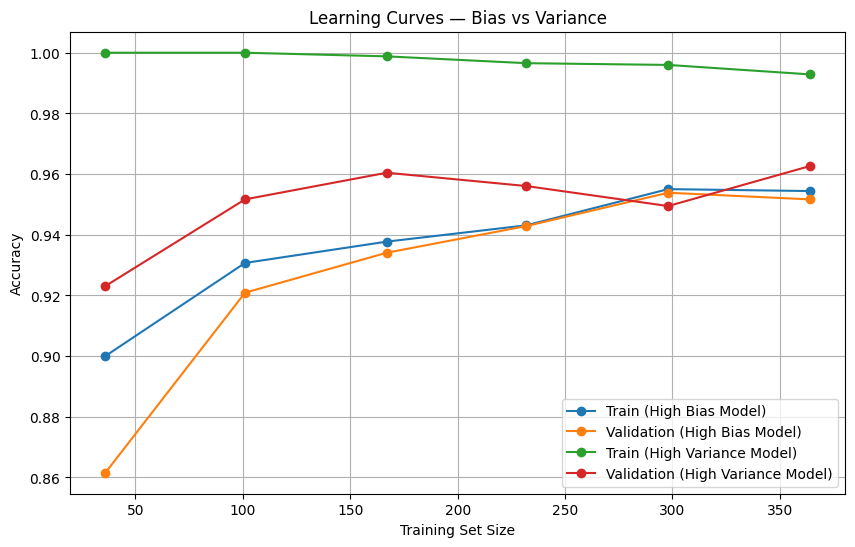

In [7]:
# Compute mean scores
train_mean_bias = np.mean(train_scores_bias, axis=1)
val_mean_bias = np.mean(val_scores_bias, axis=1)

train_mean_var = np.mean(train_scores_var, axis=1)
val_mean_var = np.mean(val_scores_var, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean_bias, marker='o', label="Train (High Bias Model)")
plt.plot(train_sizes, val_mean_bias, marker='o', label="Validation (High Bias Model)")

plt.plot(train_sizes, train_mean_var, marker='o', label="Train (High Variance Model)")
plt.plot(train_sizes, val_mean_var, marker='o', label="Validation (High Variance Model)")

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves — Bias vs Variance")
plt.legend()
plt.grid(True)
plt.show()


### Interpretation
If both training and validation curves are low and close together,
the model is likely underfitting (high bias).

If training accuracy is high but validation accuracy is much lower,
the model is likely overfitting (high variance).

If validation accuracy improves as training size increases, adding more
data can help reduce overfitting.

---

### 5. Final Test Set Comparison

After diagnosing bias and variance using learning curves, we now evaluate
both models on the untouched test set.

This helps confirm whether:
- The simpler (high bias) model underfits
- The complex (high variance) model overfits

Test set performance gives a realistic estimate of how each model
would perform on new unseen data.


In [9]:
# Fit both models on full training data
high_bias_model.fit(X_train, y_train)
high_variance_model.fit(X_train, y_train)

# Evaluate on test set
test_acc_bias = high_bias_model.score(X_test, y_test)
test_acc_var = high_variance_model.score(X_test, y_test)

print("Test Accuracy (High Bias Model):", test_acc_bias)
print("Test Accuracy (High Variance Model):", test_acc_var)

Test Accuracy (High Bias Model): 0.9473684210526315
Test Accuracy (High Variance Model): 0.9649122807017544


### Interpretation

If the high bias model has lower test accuracy, it confirms that the model
is too simple and cannot capture data patterns well.

If the high variance model performs worse on the test set despite high
training accuracy, it confirms overfitting.

The best-performing model is usually the one that balances both bias
and variance effectively.

---

# Notebook Summary — Week 3 Day 2

In this notebook, we learned how to diagnose model performance issues using
learning curves and bias–variance analysis instead of blindly tuning models.

### What was done
- Loaded and split the Breast Cancer dataset into training and test sets
- Built two Logistic Regression pipelines with different regularization strengths
- Computed learning curves using cross-validation
- Plotted training and validation accuracy against dataset size
- Evaluated both models on the final test set

### Key Learnings
- Learning curves help identify underfitting (high bias) and overfitting (high variance)
- Adding more data helps mainly when a model is overfitting
- Regularization controls model complexity and affects bias–variance balance
- Model improvements should be based on diagnosis, not random tuning

### Final Outcome
The comparison of learning curves and test accuracy showed how different
regularization strengths affect generalization, helping in choosing better
model configurations.
